In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import warnings

warnings.filterwarnings('ignore') # Tắt cảnh báo cho gọn
sns.set_style("whitegrid")

ANIME_PATH = "data/anime.csv"   # Hoặc "data/anime.csv" nếu bạn để trong folder data
RATING_PATH = "data/rating.csv" # Hoặc "data/rating.csv"

print("✅ Đã import xong thư viện.")

✅ Đã import xong thư viện.


In [2]:
# Load dataset
try:
    anime_df = pd.read_csv(ANIME_PATH)
    rating_df = pd.read_csv(RATING_PATH)
    
    print(f"Dataset Loaded Successfully!")
    print(f"Anime Shape: {anime_df.shape}")
    print(f"Rating Shape: {rating_df.shape}")
    
    # Hiển thị vài dòng đầu
    print("\n--- Anime Data Head ---")
    display(anime_df.head(3))
    print("\n--- Rating Data Head ---")
    display(rating_df.head(3))
    
except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file csv. Hãy kiểm tra lại đường dẫn.")

Dataset Loaded Successfully!
Anime Shape: (12294, 7)
Rating Shape: (7813737, 3)

--- Anime Data Head ---


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262



--- Rating Data Head ---


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1


In [3]:
print("--- Trước khi xử lý ---")
print(f"Missing values in Anime:\n{anime_df.isnull().sum()}")

# 1. Xử lý Missing Values cơ bản
# - Genre: Điền "Unknown" cho anime không có thể loại
anime_df['genre'] = anime_df['genre'].fillna('Unknown')
# - Type: Điền "TV" (loại phổ biến nhất)
anime_df['type'] = anime_df['type'].fillna('TV')
# - Rating: Xóa các anime chưa có rating (vì số lượng ít và quan trọng cho model)
anime_df.dropna(subset=['rating'], inplace=True)

# 2. Xử lý Episodes (Số tập) - SỬA LỖI TẠI ĐÂY
# Bước 2a: Thay thế 'Unknown' bằng NaN
anime_df['episodes'] = anime_df['episodes'].replace('Unknown', np.nan)

# Bước 2b: Ép kiểu sang số (float). Dùng errors='coerce' để biến mọi giá trị lỗi khác thành NaN
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')

# Bước 2c: Bây giờ cột đã là số, ta mới tính được median
median_val = anime_df['episodes'].median()
anime_df['episodes'].fillna(median_val, inplace=True)

# 3. Loại bỏ Duplicate (Trùng lặp)
anime_df.drop_duplicates(subset=['anime_id'], inplace=True)
rating_df.drop_duplicates(inplace=True)

# 4. Xử lý Outlier & Nhiễu trong Rating
# - Loại bỏ rating -1 (user đã xem nhưng không chấm điểm)
rating_clean = rating_df[rating_df['rating'] != -1].copy()

# - Lọc bớt User ít tương tác (Cold-start): Chỉ giữ user đánh giá > 50 anime
min_ratings_threshold = 50
user_counts = rating_clean['user_id'].value_counts()
active_users = user_counts[user_counts >= min_ratings_threshold].index
rating_filtered = rating_clean[rating_clean['user_id'].isin(active_users)]

# Chỉ giữ lại rating của các anime tồn tại trong bảng anime_df
rating_filtered = rating_filtered[rating_filtered['anime_id'].isin(anime_df['anime_id'])]

print("\n--- Sau khi xử lý ---")
print(f"Anime còn lại: {anime_df.shape[0]}")
print(f"Rating gốc: {rating_df.shape[0]}")
print(f"Rating sau khi lọc sạch: {rating_filtered.shape[0]}")

--- Trước khi xử lý ---
Missing values in Anime:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

--- Sau khi xử lý ---
Anime còn lại: 12064
Rating gốc: 7813736
Rating sau khi lọc sạch: 5696053


In [4]:
# Sử dụng TF-IDF để chuyển đổi cột 'genre' thành vector số học
# Token_pattern=r'[^,]+' nghĩa là tách từ dựa trên dấu phẩy (vì genre dạng "Action, Adventure")

tfidf = TfidfVectorizer(token_pattern=r'[^,]+', stop_words='english')
tfidf_matrix = tfidf.fit_transform(anime_df['genre'])

print("✅ Đã tạo ma trận TF-IDF thành công.")
print(f"Kích thước ma trận TF-IDF: {tfidf_matrix.shape}")
# Hàng = Số lượng Anime, Cột = Số lượng Genre độc nhất

✅ Đã tạo ma trận TF-IDF thành công.
Kích thước ma trận TF-IDF: (12064, 83)


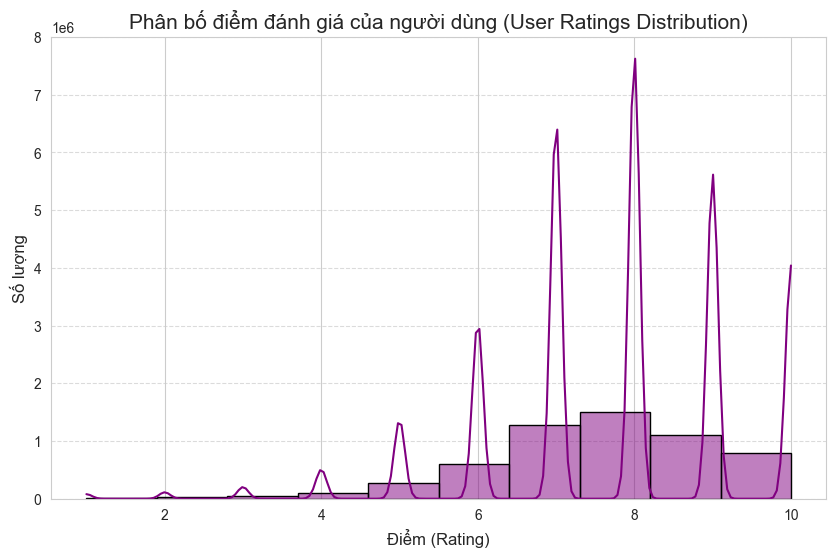

In [5]:
plt.figure(figsize=(10, 6))

sns.histplot(data=rating_filtered, x='rating', bins=10, kde=True, color='purple', edgecolor='black')

plt.title('Phân bố điểm đánh giá của người dùng (User Ratings Distribution)', fontsize=15)
plt.xlabel('Điểm (Rating)', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Nhận xét: Phân phối thường lệch về phía tích cực (7-8 điểm), ít người chấm 1-4 điểm.

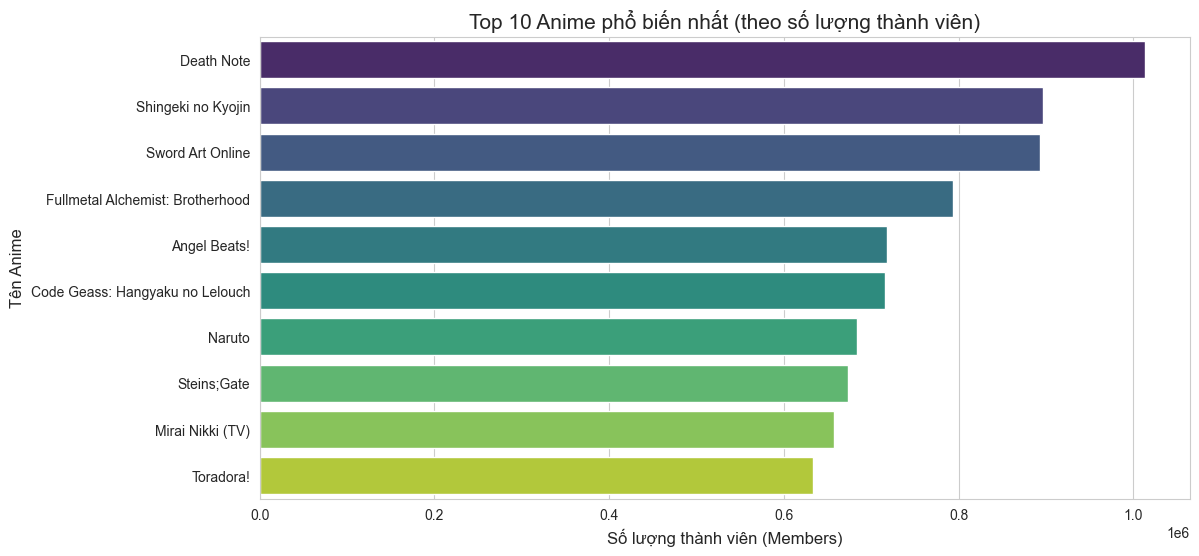

In [6]:
# Lấy Top 10 anime có lượng thành viên (members) đông nhất
top_anime = anime_df.sort_values(by='members', ascending=False).head(10)

plt.figure(figsize=(12, 6))

sns.barplot(x='members', y='name', data=top_anime, palette='viridis')

plt.title('Top 10 Anime phổ biến nhất (theo số lượng thành viên)', fontsize=15)
plt.xlabel('Số lượng thành viên (Members)', fontsize=12)
plt.ylabel('Tên Anime', fontsize=12)
plt.show()

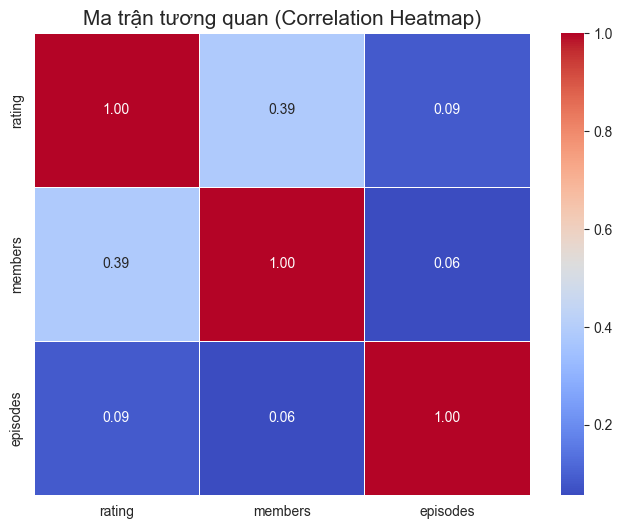

In [7]:
# Xem mối tương quan giữa: Rating trung bình, Số lượng thành viên, Số tập
correlation_data = anime_df[['rating', 'members', 'episodes']].corr()

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Ma trận tương quan (Correlation Heatmap)', fontsize=15)
plt.show()

# Nhận xét: Thường có tương quan dương giữa 'rating' và 'members' (phim hay thì nhiều người xem).

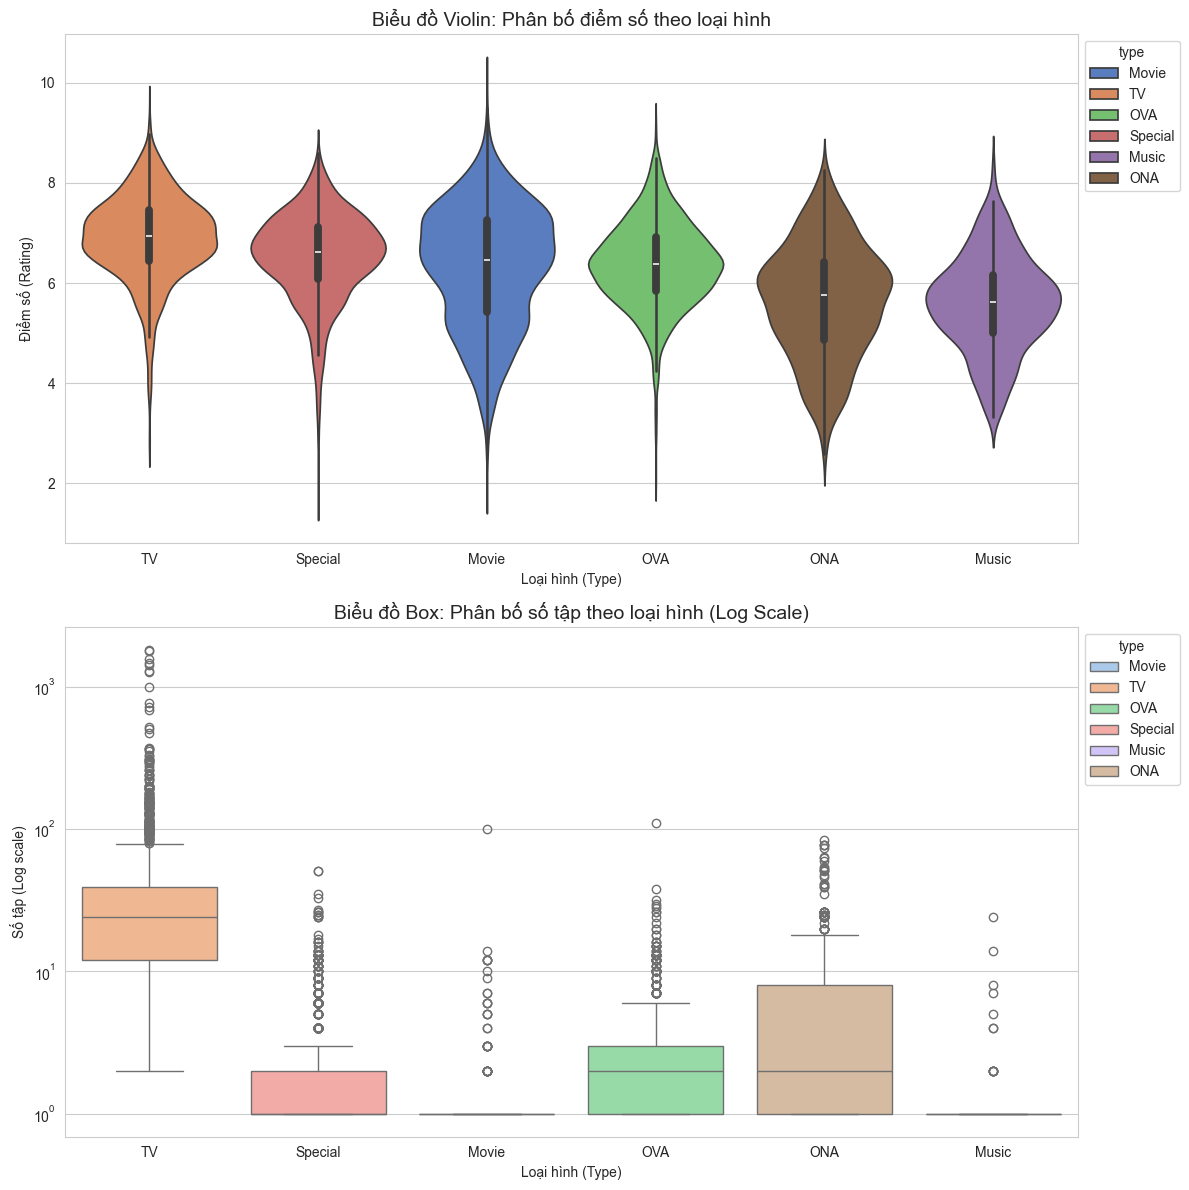

In [8]:
# Cấu hình kích thước chung
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# 1. Violin Plot: Phân bố Rating theo Type
order_type = anime_df.groupby('type')['rating'].median().sort_values(ascending=False).index

# THAY ĐỔI: Thêm hue='type' và legend=True (hoặc 'auto')
sns.violinplot(x='type', y='rating', hue='type', data=anime_df, 
               order=order_type, palette='muted', ax=ax[0], legend=True)

ax[0].set_title('Biểu đồ Violin: Phân bố điểm số theo loại hình', fontsize=14)
ax[0].set_xlabel('Loại hình (Type)')
ax[0].set_ylabel('Điểm số (Rating)')
# Di chuyển chú thích sang góc để không che dữ liệu (tùy chọn)
sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))

# 2. Box Plot: Phân bố Số tập theo Type
sns.boxplot(x='type', y='episodes', hue='type', data=anime_df, 
            order=order_type, palette='pastel', ax=ax[1], legend=True)

ax[1].set_yscale('log') 
ax[1].set_title('Biểu đồ Box: Phân bố số tập theo loại hình (Log Scale)', fontsize=14)
ax[1].set_xlabel('Loại hình (Type)')
ax[1].set_ylabel('Số tập (Log scale)')
# Di chuyển chú thích sang góc phải ngoài biểu đồ
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

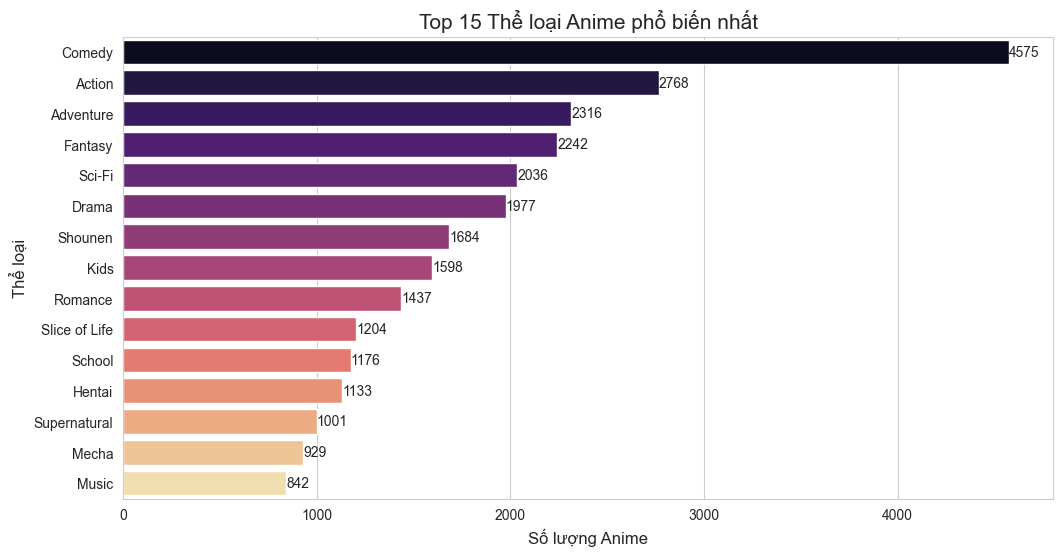

In [9]:
from collections import Counter

# 1. Tách chuỗi thể loại và đếm
genres_list = []
for genres in anime_df['genre']:
    if isinstance(genres, str):
        # Tách chuỗi "Action, Comedy" thành list ["Action", "Comedy"]
        genres_list.extend([g.strip() for g in genres.split(',')])

# 2. Đếm số lượng mỗi thể loại
genre_counts = Counter(genres_list)
genre_df = pd.DataFrame(genre_counts.most_common(15), columns=['Genre', 'Count'])

# 3. Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Genre', data=genre_df, palette='magma')

plt.title('Top 15 Thể loại Anime phổ biến nhất', fontsize=15)
plt.xlabel('Số lượng Anime', fontsize=12)
plt.ylabel('Thể loại', fontsize=12)

# Thêm số liệu lên đầu mỗi thanh
for index, value in enumerate(genre_df['Count']):
    plt.text(value, index, str(value), va='center')

plt.show()

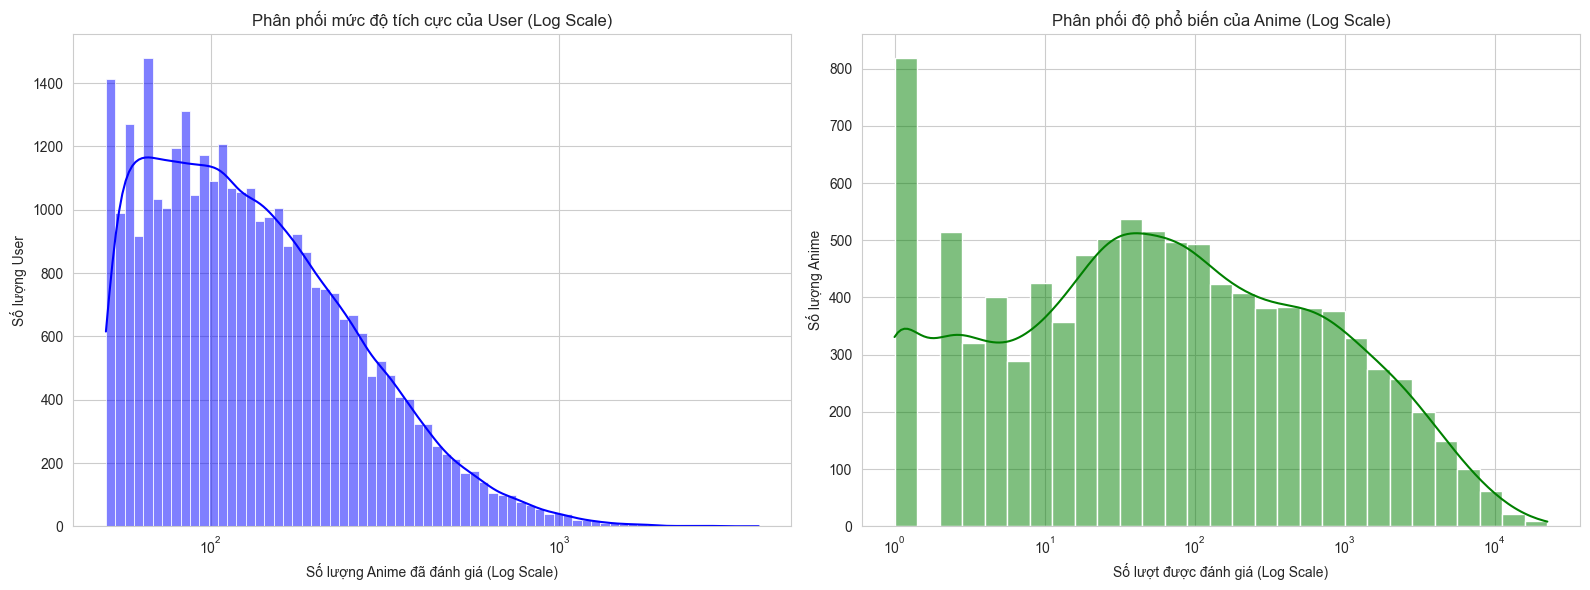

In [10]:
# Tính toán số lượng rating cho mỗi User và mỗi Anime
user_rating_counts = rating_filtered.groupby('user_id')['rating'].count()
anime_rating_counts = rating_filtered.groupby('anime_id')['rating'].count()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Phân phối số lượng Rating của User (Log Scale)
# Dùng log scale vì sự chênh lệch rất lớn (người rate 10 cái, người rate 1000 cái)
sns.histplot(user_rating_counts, kde=True, log_scale=True, ax=ax[0], color='blue')
ax[0].set_title('Phân phối mức độ tích cực của User (Log Scale)')
ax[0].set_xlabel('Số lượng Anime đã đánh giá (Log Scale)')
ax[0].set_ylabel('Số lượng User')

# 2. Phân phối số lượng Rating của Anime (Log Scale)
sns.histplot(anime_rating_counts, kde=True, log_scale=True, ax=ax[1], color='green')
ax[1].set_title('Phân phối độ phổ biến của Anime (Log Scale)')
ax[1].set_xlabel('Số lượt được đánh giá (Log Scale)')
ax[1].set_ylabel('Số lượng Anime')

plt.tight_layout()
plt.show()

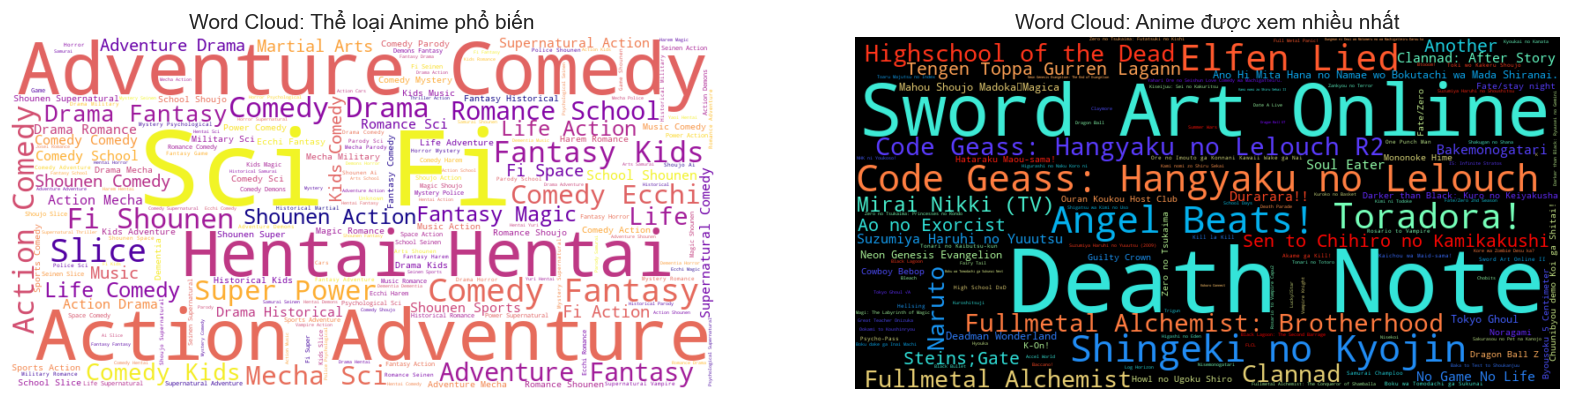

In [11]:
from wordcloud import WordCloud

# 1. Word Cloud cho Thể loại (Genre)
# Gom tất cả genre thành một chuỗi văn bản dài
all_genres = " ".join(anime_df['genre'].dropna().astype(str))
# Xử lý chuỗi: thay dấu phẩy bằng khoảng trắng
all_genres = all_genres.replace(',', '')

# 2. Word Cloud cho Tên Anime (Dựa trên độ phổ biến)
# Tạo dictionary: {Tên Anime: Số lượng Rating}
anime_popularity = rating_filtered['anime_id'].value_counts()
# Map ID sang Tên
anime_names = anime_df.set_index('anime_id')['name'].to_dict()
name_freq = {anime_names[id]: count for id, count in anime_popularity.items() if id in anime_names}

# Vẽ biểu đồ
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Genre Cloud
wc_genre = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(all_genres)
ax[0].imshow(wc_genre, interpolation='bilinear')
ax[0].set_title('Word Cloud: Thể loại Anime phổ biến', fontsize=15)
ax[0].axis('off')

# Name Cloud
wc_name = WordCloud(width=800, height=400, background_color='black', colormap='rainbow').generate_from_frequencies(name_freq)
ax[1].imshow(wc_name, interpolation='bilinear')
ax[1].set_title('Word Cloud: Anime được xem nhiều nhất', fontsize=15)
ax[1].axis('off')

plt.show()

In [12]:
# Lưu file đã xử lý
anime_df.to_csv('data/anime_cleaned.csv', index=False)
rating_filtered.to_csv('data/rating_cleaned.csv', index=False)

print("✅ Đã lưu file 'anime_cleaned.csv' và 'rating_cleaned.csv' thành công!")
print("Bạn có thể dùng 2 file này cho phần Training Model tiếp theo.")

✅ Đã lưu file 'anime_cleaned.csv' và 'rating_cleaned.csv' thành công!
Bạn có thể dùng 2 file này cho phần Training Model tiếp theo.


In [13]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

rating_filtered["user_idx"] = user_encoder.fit_transform(rating_filtered["user_id"])
rating_filtered["item_idx"] = item_encoder.fit_transform(rating_filtered["anime_id"])

num_users = rating_filtered["user_idx"].nunique()
num_items = rating_filtered["item_idx"].nunique()

user_item_matrix = csr_matrix(
    (rating_filtered["rating"],
     (rating_filtered["user_idx"], rating_filtered["item_idx"])),
    shape=(num_users, num_items)
)

user_item_matrix.shape

(32967, 9906)

In [15]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=64, random_state=42)

# Fit trên user-item matrix
user_emb_cf = svd.fit_transform(user_item_matrix)

# Item embedding lấy từ components_
item_emb_cf = svd.components_.T


In [16]:
print(user_emb_cf.shape)  # (num_users, 64)
print(item_emb_cf.shape)  # (num_items, 64)

(32967, 64)
(9906, 64)


In [17]:
tfidf = TfidfVectorizer(
    token_pattern=r'[^,]+',
    max_features=200
)

genre_emb = tfidf.fit_transform(anime_df["genre"])
genre_emb.shape


(12064, 83)